#### Name: Hui Gong
#### Instructor: Dr.Barbosa
#### CSCI 6350-001
#### Project: Graduate Project
#### Due: April 14,2020 Monday
#### Description: Semantic Similarity of Question Pairs

In [162]:
import nltk
import gensim
import math
import json
import random
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
from nltk.corpus import opinion_lexicon
from sklearn.utils import resample
from nltk.util import ngrams
from nltk.stem import PorterStemmer 
from nltk.corpus import wordnet as wn
from nltk.corpus import stopwords
from gensim.models import Word2Vec
from nltk.corpus import brown
from nltk import pos_tag
from stanfordcorenlp import StanfordCoreNLP
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.linalg import norm
from time import time
from nltk.data import find
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support as score
import os
import warnings

In [2]:
word2vec_sample = str(find('models/word2vec_sample/pruned.word2vec.txt'))
model = gensim.models.KeyedVectors.load_word2vec_format(word2vec_sample, binary=False) # load in word2vec format
vocab = set(model.vocab)


### Step 1: data processing

In [45]:
def dataPreprocess(q1, q2):
    q1,q2 = tokenize(q1, q2)
    #q1, q2 = removeStopWords(q1,q2)
    q1, q2 = stem(q1,q2)
    
    return q1, q2

# input q1,q2: string 
# return list of words for each question
def tokenize(q1, q2):
    return word_tokenize(q1.lower()), word_tokenize(q2.lower())

# input list output list
stop_words = set(stopwords.words("english"))
def removeStopWords(q1, q2):
    w1 = []
    w2 = []    
    for w in q1:
        if w not in stop_words:
            w1.append(w)
    for w in q2:
        if w not in stop_words:
            w2.append(w)
    return w1, w2

#input list output list
def stem(q1,q2):
    ps = PorterStemmer()
    stem_q1 = []
    stem_q2 = []
    for w in q1:
        stem_q1.append(ps.stem(w))
    for w in q2:
        stem_q2.append(ps.stem(w))
    return stem_q1, stem_q2

# input q1,q2: list of words
# return list of POS for each list
def posTag(q1, q2):
    return nltk.pos_tag(q1), nltk.pos_tag(q2)

### Step 2: Feature Extract


In [163]:

# feature 1 TF-IDF
def tfidf_features(s1, s2):
    cv = TfidfVectorizer(tokenizer=lambda s: s.split())
    corpus = [s1, s2]
    vectors = cv.fit_transform(corpus).toarray()
    return vectors

# feature 2 word2vector, calculate the average word vector for a given question
def word2vector_features(sentence, model, num_features, vocab):
    #words = sentence.split()
    words = word_tokenize(sentence)
    feature_vec = np.zeros((num_features, ), dtype='float32')
    n_words = 0
    for word in words:
        if word in vocab:
            n_words += 1
            feature_vec = np.add(feature_vec, model[word])
    if (n_words > 0):
        feature_vec = np.divide(feature_vec, n_words)
    return feature_vec

# Feature 3
# check if two questions have the same interrogative words
# input string
# return 0 if the same, otherwise return 1
def interrogative_features(q1, q2):
    interrogative = ["who","whose","when","where","what","which",'how']
    q1,q2 = dataPreprocess(q1,q2)
    q1_interrogative = []
    q2_interrogative = []
    #q1_tag, q2_tag = nltk.pos_tag(q1),nltk.pos_tag(q2)

    for i in interrogative:
        if i in q1:
            q1_interrogative.append(1)
        else:
            q1_interrogative.append(0)
        if i in q2:
            q2_interrogative.append(1)
        else:
            q2_interrogative.append(0)
            
    return q1_interrogative, q2_interrogative


### Step 3: Model


In [ ]:
def cosine_similarity(res1, res2):
    return np.dot(res1, res2) / (norm(res1) * norm(res2))


# word move distance
# the similiar is the distance is smaller
def feature_wmdistance(s1,s2):
    #s1, s2 = lowercase(s1, s2)
    s1, s2 = tokenize(s1, s2)
    s1,s2 = stem(s1, s2)
    res = model.wmdistance(s1,s2)
    if res == float("inf"):
        return 2
        
    return res

### Read in the raw data

In [187]:
df = pd.read_csv("train_100k.csv")
# random shuffle
# df = df.sample(frac=1)
row = df.shape[0]  
print("Size of dataset: ", row)
size_1 = math.floor(row*0.8)   # train size

df_q1 = df.loc[:size_1,'question1']
df_q2 = df.loc[:size_1,'question2']
df_is_duplicate = df.loc[:size_1,'is_duplicate']

df_q1_test = df.loc[size_1+1:,'question1']
df_q2_test = df.loc[size_1+1:,'question2']
df_is_duplicate_test = df.loc[size_1+1:,'is_duplicate']

Size of dataset:  100000


### Train the model (time: 570s)

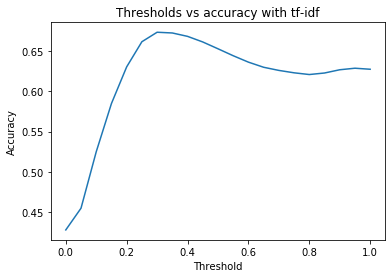

    threshold  Accuracy  Precision    Recall  F1-score
0        0.00  0.427550   0.697112  0.543837  0.611009
1        0.05  0.454575   0.702915  0.565372  0.626686
2        0.10  0.524825   0.711015  0.619886  0.662331
3        0.15  0.584900   0.705843  0.661289  0.682840
4        0.20  0.630537   0.697492  0.686369  0.691886
5        0.25  0.661837   0.688839  0.696172  0.692486
6        0.30  0.673650   0.673475  0.685532  0.679450
7        0.35  0.672737   0.656390  0.663007  0.659682
8        0.40  0.668525   0.643891  0.641403  0.642645
9        0.45  0.661550   0.631651  0.618383  0.624946
10       0.50  0.653062   0.619209  0.596658  0.607724
11       0.55  0.644413   0.606157  0.573611  0.589435
12       0.60  0.636425   0.592599  0.554800  0.573077
13       0.65  0.630050   0.578958  0.538119  0.557792
14       0.70  0.626138   0.568042  0.528110  0.547349
15       0.75  0.623150   0.555926  0.518729  0.536684
16       0.80  0.621000   0.539456  0.509607  0.524107
17       0

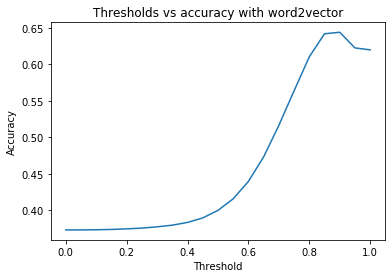

    threshold  Accuracy  Precision    Recall  F1-score
0        0.00  0.372800   0.617346  0.500182  0.552622
1        0.05  0.372812   0.619647  0.500192  0.553548
2        0.10  0.373013   0.642873  0.500351  0.562728
3        0.15  0.373450   0.661741  0.500700  0.570065
4        0.20  0.374250   0.672789  0.501337  0.574545
5        0.25  0.375275   0.673784  0.502141  0.575435
6        0.30  0.377050   0.677769  0.503548  0.577811
7        0.35  0.379312   0.677770  0.505324  0.578979
8        0.40  0.383100   0.677469  0.508287  0.580809
9        0.45  0.389275   0.675953  0.513078  0.583361
10       0.50  0.399625   0.675564  0.521087  0.588355
11       0.55  0.415538   0.675116  0.533283  0.595876
12       0.60  0.439412   0.671564  0.551027  0.605354
13       0.65  0.473037   0.666541  0.574925  0.617352
14       0.70  0.516338   0.659448  0.603158  0.630048
15       0.75  0.563738   0.651596  0.629410  0.640311
16       0.80  0.610375   0.641591  0.645355  0.643468
17       0

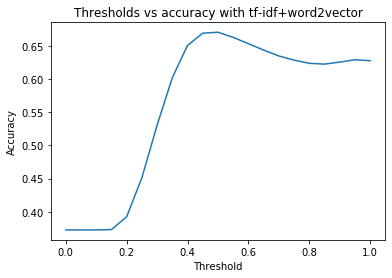

    threshold  Accuracy  Precision    Recall  F1-score
0        0.00  0.372713   0.686301  0.500139  0.578615
1        0.05  0.372713   0.686301  0.500139  0.578615
2        0.10  0.372713   0.686301  0.500139  0.578615
3        0.15  0.373237   0.686399  0.500558  0.578930
4        0.20  0.392562   0.690075  0.515957  0.590447
5        0.25  0.451275   0.701786  0.562709  0.624599
6        0.30  0.530450   0.709494  0.623769  0.663875
7        0.35  0.602062   0.703466  0.671741  0.687238
8        0.40  0.650550   0.691951  0.693578  0.692763
9        0.45  0.668975   0.673436  0.685283  0.679308
10       0.50  0.670400   0.654423  0.661233  0.657810
11       0.55  0.662637   0.635468  0.629453  0.632446
12       0.60  0.653200   0.619801  0.600176  0.609830
13       0.65  0.643537   0.604868  0.573984  0.589022
14       0.70  0.634700   0.589302  0.550965  0.569489
15       0.75  0.628413   0.574724  0.533951  0.553588
16       0.80  0.623600   0.557906  0.519940  0.538255
17       0

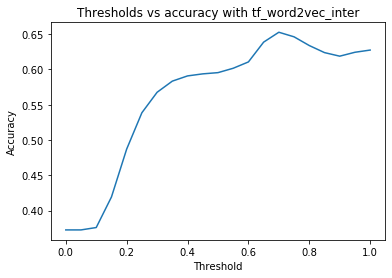

    threshold  Accuracy  Precision    Recall  F1-score
0        0.00  0.372713   0.686301  0.500139  0.578615
1        0.05  0.372713   0.686301  0.500139  0.578615
2        0.10  0.376088   0.686932  0.502829  0.580637
3        0.15  0.419325   0.689477  0.536976  0.603746
4        0.20  0.487162   0.666268  0.584844  0.622906
5        0.25  0.538663   0.649805  0.614316  0.631562
6        0.30  0.567650   0.636960  0.624798  0.630820
7        0.35  0.583438   0.628312  0.626807  0.627559
8        0.40  0.590825   0.620630  0.624003  0.622312
9        0.45  0.593725   0.613472  0.619048  0.616247
10       0.50  0.595463   0.607269  0.613869  0.610551
11       0.55  0.601662   0.605581  0.612818  0.609178
12       0.60  0.610625   0.605800  0.612980  0.609369
13       0.65  0.638663   0.622022  0.627450  0.624724
14       0.70  0.652675   0.624978  0.620492  0.622727
15       0.75  0.646188   0.610096  0.589060  0.599393
16       0.80  0.633838   0.588256  0.554326  0.570787
17       0

In [189]:
# time 570s
def train():
    start = time()
    warnings.simplefilter("ignore")
    
    cos_tfidf,cos_vect, cos_tfidf_vect, cos_all = ([] for i in range(4))
    y_actual = []

    for i in range(size_1):
        question1 = df_q1.iloc[i].lower()
        question2 = df_q2.iloc[i].lower()
        is_dup = df_is_duplicate.iloc[i]
        
        # feature tfidf matrix
        tfidf_feat = tfidf_features(question1, question2)
        q1_tfidf = tfidf_feat[0,:]
        q2_tfidf = tfidf_feat[1,:]

        # feature word2vect matrix
        q1_vect = word2vector_features(question1, model=model, num_features=300, vocab=vocab)
        q2_vect = word2vector_features(question2, model=model, num_features=300, vocab=vocab)

        # concatenate the above two feature
        q1_tfidf_vect = np.concatenate((q1_tfidf,q1_vect.transpose()),axis=0)
        q2_tfidf_vect = np.concatenate((q2_tfidf,q1_vect.transpose()),axis=0)
        
        # concatenate the above two feature + interrogative
        q1_inter, q2_inter = interrogative_features(question1, question2)
        q1_all = np.concatenate((q1_tfidf_vect,q1_inter),axis=0)
        q2_all = np.concatenate((q2_tfidf_vect,q2_inter),axis=0)

    
        
        cos_tfidf.append(cosine_similarity(q1_tfidf,q2_tfidf))
        cos_vect.append(cosine_similarity(q1_vect,q2_vect))
        cos_tfidf_vect.append(cosine_similarity(q1_tfidf_vect,q2_tfidf_vect))
        cos_all.append(cosine_similarity(q1_all,q2_all))
        
        y_actual.append(is_dup)
     
    #----------------------------------------
    thresholds = list(np.arange(0, 1.01, 0.05))
    feat_opts = ['tf-idf', 'word2vector', 'tf-idf+word2vector','tf_word2vec_inter']
    for feat_opt in feat_opts:
        
        y_predict,accuracy, precision, recall, fscore = ([] for i in range(5))
        
        for threshold in thresholds:
            if feat_opt == 'tf-idf':
                y_predict = [1 if val > threshold else 0 for val in cos_tfidf]
            elif feat_opt == 'word2vector':
                y_predict = [1 if val > threshold else 0 for val in cos_vect]
            elif feat_opt == 'tf-idf+word2vector':
                y_predict = [1 if val > threshold else 0 for val in cos_tfidf_vect]  
            else:
                y_predict = [1 if val > threshold else 0 for val in cos_all]
                
            
            accuracy.append(accuracy_score(y_actual, y_predict))
            precision_temp,recall_temp,fscore_beta,support=score(y_actual, y_predict,average='macro')
            fscore_temp =  (2 * precision_temp * recall_temp) / (precision_temp + recall_temp)
            precision.append(precision_temp)
            recall.append(recall_temp)
            fscore.append(fscore_temp)
        

        # plot thresholds vs accuracy
        fig, ax = plt.subplots()
        ax.plot(thresholds, accuracy)
        plt.xlabel('Threshold')
        plt.ylabel('Accuracy')
        plt.title('Thresholds vs accuracy with ' + feat_opt)
        plt.show()
        # save figure to given folder
        fig.savefig(os.getcwd() + '/figures/' + 'Thresholds vs accuracy with ' + feat_opt+'_'+ str(row), dpi=500)

        final_res = {'threshold':thresholds, 'Accuracy':accuracy, 'Precision':precision,'Recall':recall,'F1-score':fscore}
        final_table = pd.DataFrame(final_res, columns=['threshold', 'Accuracy', 'Precision','Recall','F1-score'])
        print(final_table)

        # save final_table to csv
        final_table.to_csv(os.getcwd() + '/results/' + 'final results with ' + feat_opt + '_'+str(row)+ '.csv')

    print("Time: ",time()-start)
    

train()

### Test model (time: 120s)

In [215]:
# time 120s
def test():
    start = time()
    warnings.simplefilter("ignore")
    
        
    size_2 = row-1 - size_1   # test data size
    
    y_test_actual,cos_tfidf_test,cos_vect_test, cos_tfidf_vect_test, cos_all_test = ([] for i in range(5))
    print("Test set size: ", size_2)
    for i in range(size_2):
        question1_test = df_q1_test.iloc[i].lower()
        question2_test = df_q2_test.iloc[i].lower()
        is_dup_test = df_is_duplicate_test.iloc[i]

        # feature tfidf matrix
        tfidf_feat_test = tfidf_features(question1_test, question2_test)
        q1_tfidf_test = tfidf_feat_test[0,:]
        q2_tfidf_test = tfidf_feat_test[1,:]

        # feature word2vect matrix
        q1_vect_test = word2vector_features(question1_test, model=model, num_features=300, vocab=vocab)
        q2_vect_test = word2vector_features(question2_test, model=model, num_features=300, vocab=vocab)

        # concatenate the above two feature
        q1_tfidf_vect_test = np.concatenate((q1_tfidf_test,q1_vect_test.transpose()),axis=0)
        q2_tfidf_vect_test = np.concatenate((q2_tfidf_test,q1_vect_test.transpose()),axis=0)
        
        # concatenate the above two feature + interrogative
        q1_inter_test, q2_inter_test = interrogative_features(question1_test, question2_test)
        q1_all_test = np.concatenate((q1_tfidf_vect_test,q1_inter_test),axis=0)
        q2_all_test = np.concatenate((q2_tfidf_vect_test,q2_inter_test),axis=0)

        # cosine similarity 
        cos_tfidf_test.append(cosine_similarity(q1_tfidf_test,q2_tfidf_test))
        cos_vect_test.append(cosine_similarity(q1_vect_test,q2_vect_test))
        cos_tfidf_vect_test.append(cosine_similarity(q1_tfidf_vect_test,q2_tfidf_vect_test))
        cos_all_test.append(cosine_similarity(q1_all_test,q2_all_test))
        
        y_test_actual.append(is_dup_test)
    
    #---------------------------------------
    # threshold from models
    thresholds = [0.3,0.87,0.5,0.7]
    
    feat_opts = ['tf-idf', 'word2vector', 'tf-idf+word2vector','tf_word2vec_inter']
    
    y_predict,accuracy, precision, recall, fscore = ([] for i in range(5))    
    for feat_opt in feat_opts:   
        
        if feat_opt == 'tf-idf':
            threshold = thresholds[0]
            y_predict = [1 if val > threshold else 0 for val in cos_tfidf_test]
        elif feat_opt == 'word2vector':
            threshold = thresholds[1]
            y_predict = [1 if val > threshold else 0 for val in cos_vect_test]
        elif feat_opt == 'tf-idf+word2vector':
            threshold = thresholds[2]
            y_predict = [1 if val > threshold else 0 for val in cos_tfidf_vect_test] 
        else:
            threshold = thresholds[3]
            y_predict = [1 if val > threshold else 0 for val in cos_all_test] 
                                   
        
        accuracy.append(accuracy_score(y_test_actual, y_predict))
        precision_temp,recall_temp,fscore_beta,support=score(y_test_actual, y_predict,average='macro')
        fscore_temp =  (2 * precision_temp * recall_temp) / (precision_temp + recall_temp)
        precision.append(precision_temp)
        recall.append(recall_temp)
        fscore.append(fscore_temp)

    final_res = {'threshold':thresholds, 'Accuracy':accuracy, 'Precision':precision,'Recall':recall,'F1-score':fscore}
    final_table = pd.DataFrame(final_res, columns=['threshold', 'Accuracy', 'Precision','Recall','F1-score'])
    print(final_table)

    # save final_table to csv
    final_table.to_csv(os.getcwd() + '/results/' + 'TEST_final results with ' + feat_opt + '_'+str(row)+ '.csv')

    print("Time: ",time()-start)
    
test()

Test set size:  19999
   threshold  Accuracy  Precision    Recall  F1-score
0       0.30  0.671384   0.672525  0.684506  0.678463
1       0.87  0.649132   0.625806  0.626824  0.626315
2       0.50  0.671684   0.655945  0.662956  0.659432
3       0.70  0.651983   0.624534  0.620560  0.622541
Time:  120.0303008556366
